# Convolutional Neural Networks

## Dog Breed Classifier

---

### Introduction

In this notebook, we will explore Convolutional Neural Networks by creating an app that can accept any user-supplied image, and if a dog is detected, provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the closest resembling dog breed. This project was taken from [Udacity's AI program](https://www.udacity.com/ai) which borrowed from this [Keras post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

We will start with a CNN built from scratch and then use transfer learning to improve it. To do all this, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.

### Import Dog Dataset

In the code cell below, we will import our dog image dataset. If not already done, please download and extract the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) to the `/dogImages` path. We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    """
    Function to load train, test, and validation datasets
    """
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# Print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we will import our human image dataset, where the file paths are stored in the numpy array `human_files`. If not already done, please download and extract the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip) to the `/lfw` path.

In [2]:
import random
random.seed(42)

# Load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# Print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


### Detecting Humans

Now that we have our data loaded, we need an algorithm for detecting whether our images are humans or dogs. Let's start with human detection.

We will use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). We have already downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we will demonstrate how to use this detector to find human faces in a sample image.

Before using the face detector, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.

In the code below, `faces` is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

Number of faces detected: 1


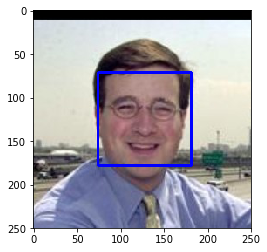

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Load color (BGR) image
img = cv2.imread(human_files[3])

# Convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(gray)

# Print number of faces detected in the image
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
def face_detector(img_path):
    """
    Returns "True" if face is detected in image stored at img_path
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Test the Human Face Detector

Ideally, we would like to see 100% of human images with a detected face and 0% of dog images with a detected face.

In [5]:
# Get test sample
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm and return percentage correct.
human_detected_human_files = len([h for h in human_files_short if face_detector(h)])
human_detected_dog_files = len([d for d in dog_files_short if face_detector(d)])

print("Percentage of humans detected in human files: {}%".format(human_detected_human_files))
print("Percentage of humans detected in dog files: {}%".format(human_detected_dog_files))

Percentage of humans detected in human files: 97%
Percentage of humans detected in dog files: 11%


We can see that our face_detector does a good job on the human dataset but makes some mistakes with the dog dataset. It is important to note that our app inputs requires a clear view of a face.

Another option is to augment the original dataset and train on human images at different angles, positions, and cut off features like heads or arms. Even with all of this, I'm sure the user will still come up with a way to confuse the app, so the limitation on inputs might still be the best strategy to avoid frustrated users.

### Detecting Dogs

In this section, we will use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# Define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset.

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    """
    Helper function for inputing data
    """
    # Loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    Helper function for inputing data
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    """
    Returns prediction vector for image located at img_path
    """
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
def dog_detector(img_path):
    """
    Returns "True" if a dog is detected in the image stored at img_path
    """
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Test the Dog Detector

We will test our dog detector on the samples we used for our face detector.

In [10]:
# Test the performance of the dog_detector function and return percentage correct
dog_detected_human_files = len([h for h in human_files_short if dog_detector(h)])
dog_detected_dog_files = len([d for d in dog_files_short if dog_detector(d)])

print("Percentage of dogs detected in human files: {}%".format(dog_detected_human_files))
print("Percentage of dogs detected in dog files: {}%".format(dog_detected_dog_files))

Percentage of dogs detected in human files: 0%
Percentage of dogs detected in dog files: 100%


The results look perfect.

So far we have created a human detector and a dog detector by using already trained open source CNNs. Let's move on to our breed classifier.

### Create a CNN From Scratch to Classify Dog Breeds

Now that we have functions for detecting humans and dogs in our images, we need a way to predict breed from images. In this step, we will create a CNN that classifies dog breeds. Our first attempt will be to build the network from scratch and then we will try transfer learning.

Our first go at this should perform pretty bad. Remeber that the task of assigning breed to dogs from images is considered exceptionally hard. To see why, consider that even a human would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# Pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:06<00:00, 133.77it/s]


### Build Model Architecture

Here, we will decide on the structure of our network. We can play around with layers, dropouts, and hyperparameters.

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Initalize model
model = Sequential()

# Convolutional layers
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       73856     
__________

We can see our basic structure above. We use 4 convolutional and max pooling layers followed by a global average pooling layer that feeds into our fully connected classifier.

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Data Augmentation

Before training, we will augment our data to create more samples at different angles and sizes. This helps prevent overfitting and helps the model generalize better.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# Create and configure augmented image generator
datagen_train = ImageDataGenerator(
    rotation_range = 20,       # randomly rotate images
    width_shift_range = 0.2,   # randomly shift images horizontally
    height_shift_range = 0.2,  # randomly shift images vertically
    zoom_range = 0.2,          # randomly zoom images
    shear_range = 0.2,         # randomly shear images
    fill_mode = 'nearest',     # Fills in newly created 
    horizontal_flip = True)    # randomly flip images horizontally

# Create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    rotation_range = 20,       # randomly rotate images
    width_shift_range = 0.2,   # randomly shift images horizontally
    height_shift_range = 0.2,  # randomly shift images vertically
    zoom_range = 0.2,          # randomly zoom images
    shear_range = 0.2,         # randomly shear images
    fill_mode = 'nearest',     # Fills in newly created 
    horizontal_flip = True)    # randomly flip images horizontally

# Fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

### Visualize Original and Augmented Images

Let's look at some of our augmented images

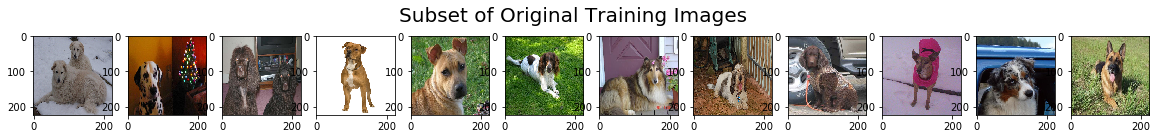

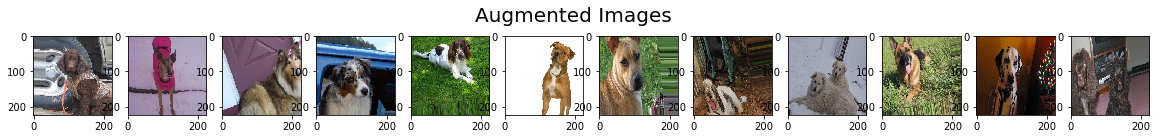

In [15]:
import matplotlib.pyplot as plt

# Take subset of training data
x_train_subset = train_tensors[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### Train the Model

Now let's train the model on our augmented data. We will use model checkpointing to save the model that attains the best validation loss.

In [16]:
from keras.callbacks import ModelCheckpoint  

# Specify the number of epochs and batch size
epochs = 20
batch_size = 20

# Initalize checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

# Train model
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 4.86847, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 4.86847 to 4.86709, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 4.86709 to 4.84416, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00004: val_loss improved from 4.84416 to 4.80265, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00005: val_loss improved from 4.80265 to 4.73582, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00006: val_loss improved from 4.73582 to 4.73400, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00007: val_loss improved from 4.73400 to 4.67392, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00008: val_loss improved from 4.67392 to 4.59056, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00009: val_loss improved from 4.

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Let's try out our model on the test dataset of dog images. If it's working, we should be able to get an accuracy better than random (>1%).

In [18]:
# Get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.6890%


We get it right about 1 out of 10 times. Not bad for our first try. Let's see if we can do any better by adding our classifier to an already trained CNN.

### Create a CNN to Classify Dog Breeds (using Transfer Learning)

Sure, we could train our CNN above for a couple of weeks and see how we do, or we could borrow from some other CNNs that are already trained and modify them to our use case. Let's try the latter which is refered to as transfer learning.

Transfer learning works because networks trained on large datasets often already learned features that are useful for other computer vision problems. For example, a network that can classify dogs from cats probably already learned many of the features that could be used to classify dogs from another animal.

One way to accomplish this transfer is to run the borrowed model on our data minus whatever classification layers it uses. So our output is just the features that the convolational layers would output. We can take that output (bottleneck) and feed it as input to our fully connected classification network. To make things easier, the pre-computed bottleneck features for multple networks can be found here:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

We will be useing the ResNet-50 model which we used earlier for detecting dogs. [Resnet50](https://arxiv.org/pdf/1512.03385.pdf) was developed by a Microsoft team and won the ImageNet competiton in 2015. Resnet 50 manages to solve the vanishing gradient problem that plagued super deep networks in the past. It does this by introducing shortcuts that directly connect layers with layers later on in the network. In this case 50 layers deep. We will add our own dog breed classification network to the end of it and see how it does.

### Obtain Bottleneck Features

In the code block below, we extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

In [81]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Model Architecture

Since our bottleneck input will already have ran through the ResNet50 CNN, we only need to add our fully connected classifier on top of it.

In [82]:
# Define our architecture.
model_Resnet50 = Sequential()
model_Resnet50.add(Flatten(input_shape=train_Resnet50.shape[1:]))
model_Resnet50.add(Dense(512, activation='relu'))
model_Resnet50.add(Dropout(0.5))
model_Resnet50.add(Dense(133, activation='softmax'))
model_Resnet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [83]:
from keras import optimizers

# Compile the model.
model_Resnet50.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
                       metrics=['accuracy'])

### Train the Model

Again, we will use model checkpointing to save the model that attains the best validation loss.  

In [84]:
# Specify the number of epochs
epochs = 500
batch_size = 20

checkpointer_Resnet50 = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5',
                                        verbose=1, save_best_only=True)

graph = model_Resnet50.fit(train_Resnet50, train_targets,
                           validation_data=(valid_Resnet50, valid_targets),
                           epochs=epochs, batch_size=batch_size, callbacks=[checkpointer_Resnet50], verbose=0)

Epoch 00000: val_loss improved from inf to 4.57769, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00001: val_loss improved from 4.57769 to 4.19889, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00002: val_loss improved from 4.19889 to 3.84241, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00003: val_loss improved from 3.84241 to 3.47858, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00004: val_loss improved from 3.47858 to 3.12468, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00005: val_loss improved from 3.12468 to 2.80074, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00006: val_loss improved from 2.80074 to 2.51743, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00007: val_loss improved from 2.51743 to 2.26930, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00008: val_loss improved from 2.26930 to 2.05929, saving model to saved_models/weights.best.Resnet50.h

Epoch 00154: val_loss improved from 0.49947 to 0.49862, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00155: val_loss improved from 0.49862 to 0.49690, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss improved from 0.49690 to 0.49585, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00161: val_loss improved from 0.49585 to 0.49487, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00162: val_loss improved from 0.49487 to 0.49469, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00163: val_loss improved from 0.49469 to 0.49412, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00164: val_loss improved from 0.49412 to 0.49318, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did 

Epoch 00452: val_loss improved from 0.46197 to 0.46109, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00453: val_loss improved from 0.46109 to 0.46086, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00454: val_loss did not improve
Epoch 00455: val_loss did not improve
Epoch 00456: val_loss did not improve
Epoch 00457: val_loss did not improve
Epoch 00458: val_loss did not improve
Epoch 00459: val_loss did not improve
Epoch 00460: val_loss did not improve
Epoch 00461: val_loss did not improve
Epoch 00462: val_loss did not improve
Epoch 00463: val_loss did not improve
Epoch 00464: val_loss did not improve
Epoch 00465: val_loss did not improve
Epoch 00466: val_loss did not improve
Epoch 00467: val_loss did not improve
Epoch 00468: val_loss did not improve
Epoch 00469: val_loss did not improve
Epoch 00470: val_loss did not improve
Epoch 00471: val_loss did not improve
Epoch 00472: val_loss did not improve
Epoch 00473: val_loss did not improve
Epoch 00474: val

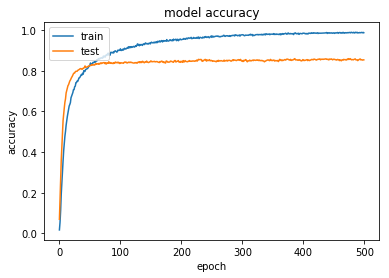

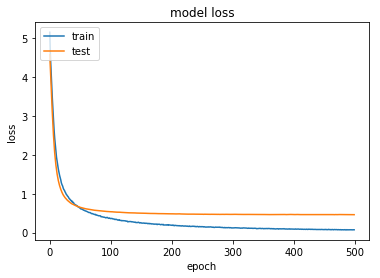

In [85]:
# Visualize training
# Summarize history for accuracy
plt.plot(graph.history['acc'])
plt.plot(graph.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load the Model with the Best Validation Loss

In [86]:
model_Resnet50.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

In [87]:
# Calculate classification accuracy on the test dataset.
# Get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(model_Resnet50.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# Report test accuracy
test_accuracy_Resnet50 = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/ \
                         len(Resnet50_predictions)
    
print('Test accuracy Resnet50: %.4f%%' % test_accuracy_Resnet50)

Test accuracy Resnet50: 85.8852%


By using the feature output of an already trained CNN, we improved our accuraccy from 9% to 85%. Not bad.

### Fine-Tune Transfer Learning Model

In the prior step we used the outputs of the pretrained ResNet50 CNN as an input to our classifier. What if we also want to modify the weights in the ResNet50 CNN to more accuratly match our use case?

This is called Fine-tuning and is pretty simple to acchomplish in Keras. First we will import ResNet50 as our base model, then add our already trained classifier on top, then freeze all the layers but the ones we want to fine tune, and then train.

In [133]:
from keras.models import Model
from keras.layers import Input

# Build the base Resnet50 Network
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

# Build our classifier model to put on top
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(133, activation='softmax'))

# Get weights from previously trained model
#top_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

# Add top model to Resnet50 base
tuned_model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# Set all but last 13 layers to be frozen
for layer in tuned_model.layers:
    layer.trainable = False
    
#for layer in tuned_model.layers[-12:]:
#    if 'activation' in layer.name:
#        layer.trainable = True
#        print(layer.name)
        
for layer in tuned_model.layers[-12:]:
    layer.trainable = True
    print(layer.name)

res5c_branch2a
bn5c_branch2a
activation_978
res5c_branch2b
bn5c_branch2b
activation_979
res5c_branch2c
bn5c_branch2c
add_320
activation_980
avg_pool
sequential_31


Here, we will only updating the last few activation layers of the ResNet model.

### Compile the Model

In [134]:
tuned_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=.0001, momentum=0.9),
                    metrics=['accuracy'])

### Train the Model on Augmented Data

In [135]:
# Specify the number of epochs and batch_size
epochs = 100
batch_size = 20

checkpointer_Resnet50_tuned = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50tuned.hdf5',
                                              verbose=1, save_best_only=True)

graph = tuned_model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                                  steps_per_epoch=train_tensors.shape[0] // batch_size,
                                  validation_data=datagen_valid.flow(valid_tensors, valid_targets,
                                                                     batch_size=batch_size),
                                  validation_steps=valid_tensors.shape[0] // batch_size,
                                  epochs=epochs, callbacks=[checkpointer_Resnet50_tuned], verbose=0)

Epoch 00000: val_loss improved from inf to 5.04904, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00001: val_loss improved from 5.04904 to 5.02807, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00002: val_loss improved from 5.02807 to 4.52142, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00003: val_loss improved from 4.52142 to 4.25705, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00004: val_loss improved from 4.25705 to 4.03445, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00005: val_loss improved from 4.03445 to 3.78286, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00006: val_loss improved from 3.78286 to 3.53855, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00007: val_loss improved from 3.53855 to 3.33390, saving model to saved_models/weights.best.Resnet50tuned.hdf5
Epoch 00008: val_loss improved from 3.33390 to 3.08577, saving model

### Load the Model with Best Validation Loss

In [136]:
tuned_model.load_weights('saved_models/weights.best.Resnet50tuned.hdf5')

### Test the Model

In [137]:
# Get index of predicted dog breed for each image in test set
tuned_predictions = [np.argmax(tuned_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(tuned_predictions)==np.argmax(test_targets, axis=1))/len(tuned_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.6316%


We didn't do as good as the bottleneck approach, but this is mainly because of computational limits. With better hardware and some time, we could unfreeze more layers and fully tune our model.

### Predict Dog Breed Application

Now let's write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model. let's use our bottlenecked model that had the best performance.

First, we need to extract the bottleneck features from our input, then run them through our model, then use the `dog_names` we found earlier to get our answers.

In [138]:
def extract_Resnet50(tensor):
    """
    Extract bottlenet feature from a tensor.
    """
    return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def predict_breed_R50(img_path):
    """
    Takes in a path to an image and returns the dog breed.
    """
    # Extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # Obtain predicted vector
    predicted_vector = model_Resnet50.predict(bottleneck_feature)
    # Return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### Put it all together

Now we put it all together and write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [139]:
def breed_detector(img_path):
    """
    Takes in a path to an image and returns whether it is a dog or a
    human and what breed it looks like.
    """
    # Find breed with helper function
    predicted_breed = predict_breed_R50(img_path)
    
    # Show the image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("Let's see what we have here!")
    plt.imshow(cv_rgb)
    plt.show()
    
    # Check if dog or human with OpenCV's detector.
    if dog_detector(img_path):
        print("That's a dog. It looks like a " + str(predicted_breed))
    elif face_detector(img_path):
        print("That's a human, but it looks like a " + str(predicted_breed))
    else:
        print("I'm not sure what that is. Are you trying to trick me?")

### Test Our Algorithm

Let's test on four categories (cats, dogs, humans, random).

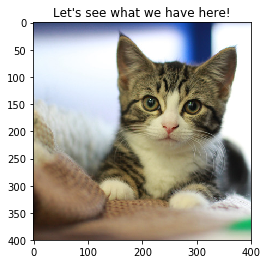

I'm not sure what that is. Are you trying to trick me?


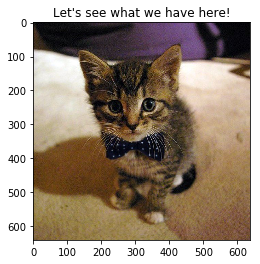

I'm not sure what that is. Are you trying to trick me?


In [140]:
# Test on cats
breed_detector("test_images/cat1.jpg")
breed_detector("test_images/cat2.jpeg")

For cats, the model performed as expected and didn't confuse either for a dog.

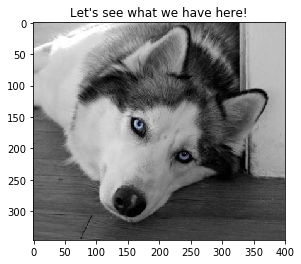

That's a dog. It looks like a Alaskan_malamute


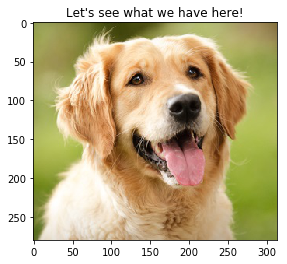

That's a dog. It looks like a Golden_retriever


In [141]:
# Test on dogs
breed_detector("test_images/siberianhuskey.jpg")
breed_detector("test_images/goldenretriever.jpg")

For dogs, the model got the golden retriever right but missed the siberian huskey. In it's defense, they do look like Alaskan Malamutes.

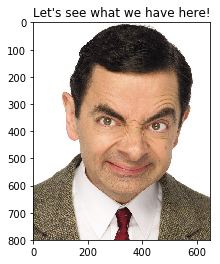

That's a human, but it looks like a Beagle


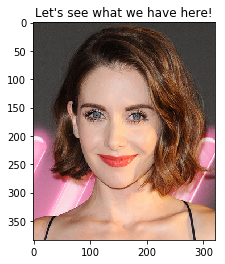

That's a human, but it looks like a Chinese_crested


In [142]:
# Test on humans
breed_detector("test_images/human1.jpg")
breed_detector("test_images/human2.jpg")

For humans, the model performed as expected and classified both as humans.

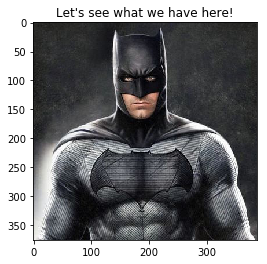

I'm not sure what that is. Are you trying to trick me?


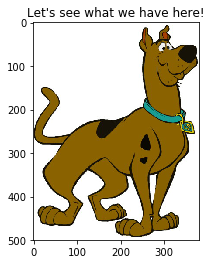

That's a dog. It looks like a Canaan_dog


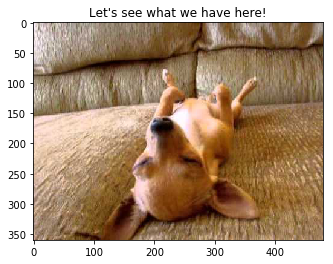

That's a dog. It looks like a German_pinscher


In [143]:
# Test on random
breed_detector("test_images/random1.jpg")
breed_detector("test_images/random2.jpg")
breed_detector("test_images/upsidedowndog.jpg")

For random, the model couldnt figure out that a man dressed up like batman was still human. It did figure out that scooby doo and an upside down chihuahua were both dogs, but missed their breed.

To improve our model, we could add more layers to our classifier fine tune the base model for longer periods of time on augmented data.